In [83]:
import praw
import pandas as pd
from datetime import datetime, timedelta
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.dates as pdt
import mysql.connector
import re
from tqdm import tqdm

In [84]:
db_connection = mysql.connector.connect(
  host= "wp.jagi.wtf",
  user= "redditu",
  password= "redditMaster",
  database="reddit"
  )


In [85]:
cursor = db_connection.cursor()

In [86]:
dfs = pd.read_sql("SELECT * FROM spoonacular", db_connection)

### 16. Anteil vegane/vegetarische/fleischhaltige Gerichte

In [87]:
dfs_wod = dfs.drop_duplicates(subset=["url"])
parts = dfs_wod[["vegetarian", "vegan"]].sum()
fges = dfs_wod["vegetarian"].count()
fvegn = dfs_wod["vegan"].sum()
fvegt = dfs_wod["vegetarian"].sum() - fvegn
frest = fges - fvegt - fvegn

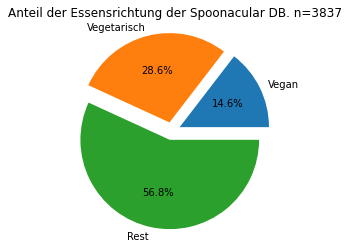

In [88]:
plt.pie([fvegn, fvegt, frest], 
        labels=["Vegan", "Vegetarisch", "Rest"],
       autopct='%1.1f%%', explode=(0.1,0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Essensrichtung der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 17. Anteil laktosefreie Gerichte

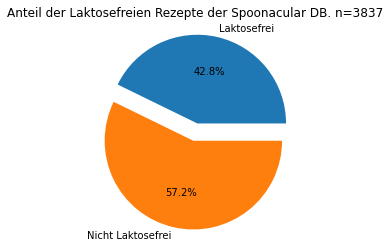

In [89]:
plt.pie([dfs_wod["dairy_free"].sum(), 
         dfs_wod["dairy_free"].count() - dfs_wod["dairy_free"].sum()], 
        labels=["Laktosefrei", "Nicht Laktosefrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Laktosefreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["dairy_free"].count()))
plt.show()

### 18. Anteil glutenfreier Gerichte

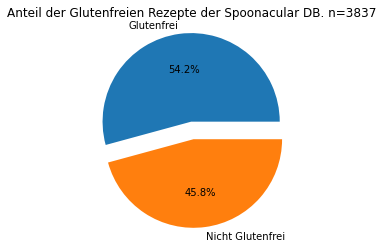

In [90]:
plt.pie([dfs_wod["gluten_free"].sum(), 
         dfs_wod["gluten_free"].count() - dfs_wod["gluten_free"].sum()], 
        labels=["Glutenfrei", "Nicht Glutenfrei"],
       autopct='%1.1f%%', explode=(0.1,0.1))
plt.axis('equal')
plt.title("Anteil der Glutenfreien Rezepte der Spoonacular DB. n=" + str(dfs_wod["gluten_free"].count()))
plt.show()

### 19. Bewertung im Verhältnis zu Inhaltsstoffen

#### a) Zucker

In [91]:
dfs_wod.insert(loc=0, column="likes/sugar", value=(dfs_wod["likes"]/dfs_wod["sugar"]))

#### b) Fett

In [92]:
dfs_wod.insert(loc=0, column="likes/fat", value=(dfs_wod["likes"]/dfs_wod["fat"]))

#### c) Kalorien

In [93]:
dfs_wod.insert(loc=0, column="likes/calories", value=(dfs_wod["likes"]/dfs_wod["calories"]))

In [94]:
dfs_wod.head()

,likes/calories,likes/fat,likes/sugar,id,vegetarian,vegan,gluten_free,dairy_free,likes,ready_in_minutes,url,calories,sugar,fat,ingredients,cuisine,title,type
0,0.102905,7.294118,1.393258,5,0,0,1,1,124,45,https://spoonacular.com/african-chicken-peanut...,1205,89,17,"{""0"": ""bell peppers"", ""1"": ""chicken"", ""2"": ""co...",African,African Chicken Peanut Stew,None
1,0.005319,0.125000,0.200000,6,1,1,1,1,1,45,https://spoonacular.com/african-bean-soup-632003,188,5,8,"{""0"": ""black eyed peas"", ""1"": ""carrots"", ""2"": ...",African,African Bean Soup,None
4,0.685771,57.833333,173.500000,9,1,1,1,1,347,45,https://spoonacular.com/how-to-make-party-joll...,506,2,6,"{""0"": ""bay leaves"", ""1"": ""curry powder"", ""2"": ...",African,How to Make Party Jollof Rice,None
5,0.002770,0.333333,0.166667,10,1,1,0,1,1,45,https://spoonacular.com/north-african-chickpea...,361,6,3,"{""0"": ""canola oil"", ""1"": ""garlic"", ""2"": ""onion...",African,North African Chickpea Soup,None
6,4.782235,inf,111.266667,11,1,1,0,1,1669,45,https://spoonacular.com/homemade-garlic-and-ba...,349,15,0,"{""0"": ""basil"", ""1"": ""flour"", ""2"": ""garlic powd...",American,Homemade Garlic and Basil French Fries,None


In [95]:
dfs_filtered = dfs_wod[(dfs_wod["likes"]>3) & (dfs_wod["sugar"]>0) & (dfs_wod["likes"]>dfs_wod["likes"].quantile(0.8))].describe()

In [96]:
dfs_filtered = dfs_wod[(dfs_wod["likes/sugar"] < dfs_wod["likes/sugar"].quantile(0.8))]

In [97]:
dfs_wod.describe()

,likes/calories,likes/fat,likes/sugar,id,vegetarian,vegan,gluten_free,dairy_free,likes,ready_in_minutes,calories,sugar,fat
count,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000
mean,0.397646,inf,inf,3976.267396,0.431587,0.145687,0.542351,0.427678,113.235340,48.633568,365.232473,18.363044,12.698984
std,9.175327,NaN,NaN,2370.323227,0.495362,0.352838,0.498268,0.494806,1967.793798,39.356976,228.670230,15.576155,13.756706
min,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000
25%,0.002538,0.083333,0.052632,2318.000000,0.000000,0.000000,0.000000,0.000000,1.000000,45.000000,188.000000,7.000000,4.000000
50%,0.005128,0.200000,0.125000,4128.000000,0.000000,0.000000,1.000000,0.000000,1.000000,45.000000,329.000000,14.000000,8.000000
75%,0.014388,0.750000,0.500000,5972.000000,1.000000,0.000000,1.000000,1.000000,3.000000,45.000000,503.000000,26.000000,16.000000
max,487.508197,inf,inf,7789.000000,1.000000,1.000000,1.000000,1.000000,65477.000000,660.000000,1682.000000,115.000000,87.000000


Text(0.5, 1.0, 'Likes')

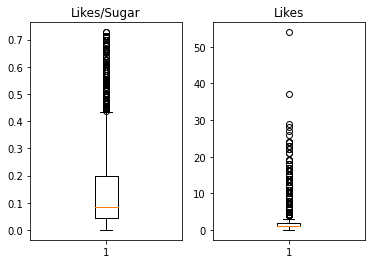

In [98]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.boxplot(dfs_filtered["likes/sugar"])
ax1.set_title("Likes/Sugar")
ax2.boxplot(dfs_filtered["likes"])
ax2.set_title("Likes")

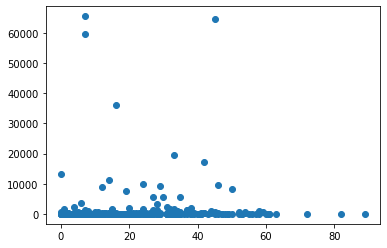

In [99]:
dfs_filtered = dfs_wod[(dfs_wod["likes"] > dfs_wod["likes"].quantile(0.9))]
plt.scatter(dfs_filtered["sugar"], dfs_filtered["likes"])

(array([1.614e+03, 1.034e+03, 6.370e+02, 2.840e+02, 1.750e+02, 4.900e+01,
        2.500e+01, 1.200e+01, 6.000e+00, 1.000e+00]),
 array([  0. ,  11.5,  23. ,  34.5,  46. ,  57.5,  69. ,  80.5,  92. ,
        103.5, 115. ]),
 <BarContainer object of 10 artists>)

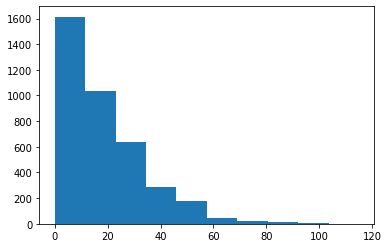

In [100]:
plt.hist(dfs_wod["sugar"])

/home/jakob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  


ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

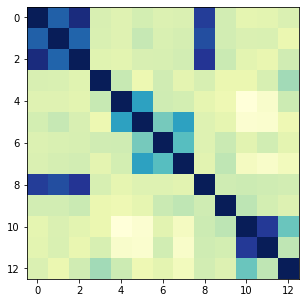

In [115]:
x = dfs_filtered.corr()
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.imshow(x, cmap="YlGnBu")

ax.set_xticks(range(len(x)),x.columns)

ax.set_yticks(range(len(x)),x.index)

fig.plot()

Aufgrund der Korrelationstabelle lässt sich ableiten, dass sich kein Zusammenhang zwischen Zutaten und Likes sowie der Zubereitungszeit und den Likes erkennen

1.0

In [120]:
p_dairy_free = dfs_wod["dairy_free"].sum()/dfs_wod["dairy_free"].count()
p_vegan = dfs_wod["vegan"].sum()/dfs_wod["vegan"].count()
p_vegan_and_dairy_free = dfs_wod[(dfs_wod["dairy_free"]==1) & (dfs_wod["vegan"]==1)]["vegan"].sum()/dfs_wod["dairy_free"].count()


In [121]:
p_a_b = p_vegan_and_dairy_free/p_dairy_free

p_b_a = p_vegan_and_dairy_free/p_vegan

In [122]:
print(f"P(A|B) = {p_a_b} und P(B|A) = {p_b_a}")

P(A|B) = 0.34064594759293115 und P(B|A) = 1.0


In [108]:
dfs_wod.describe()

,likes/calories,likes/fat,likes/sugar,id,vegetarian,vegan,gluten_free,dairy_free,likes,ready_in_minutes,calories,sugar,fat
count,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000,3837.000000
mean,0.397646,inf,inf,3976.267396,0.431587,0.145687,0.542351,0.427678,113.235340,48.633568,365.232473,18.363044,12.698984
std,9.175327,NaN,NaN,2370.323227,0.495362,0.352838,0.498268,0.494806,1967.793798,39.356976,228.670230,15.576155,13.756706
min,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,0.000000,0.000000
25%,0.002538,0.083333,0.052632,2318.000000,0.000000,0.000000,0.000000,0.000000,1.000000,45.000000,188.000000,7.000000,4.000000
50%,0.005128,0.200000,0.125000,4128.000000,0.000000,0.000000,1.000000,0.000000,1.000000,45.000000,329.000000,14.000000,8.000000
75%,0.014388,0.750000,0.500000,5972.000000,1.000000,0.000000,1.000000,1.000000,3.000000,45.000000,503.000000,26.000000,16.000000
max,487.508197,inf,inf,7789.000000,1.000000,1.000000,1.000000,1.000000,65477.000000,660.000000,1682.000000,115.000000,87.000000


In [106]:
dfs_wod[(dfs_wod["vegan"] == 1) & (dfs_wod["dairy_free"] == 1)].describe()

,likes/calories,likes/fat,likes/sugar,id,vegetarian,vegan,gluten_free,dairy_free,likes,ready_in_minutes,calories,sugar,fat
count,559.000000,559.0,559.000000,559.000000,559.0,559.0,559.000000,559.0,559.000000,559.000000,559.000000,559.000000,559.000000
mean,0.431117,inf,inf,3754.355993,1.0,1.0,0.822898,1.0,49.311270,45.747764,246.474061,10.667263,10.663685
std,6.364398,NaN,NaN,2059.074470,0.0,0.0,0.382097,0.0,587.852991,25.530972,167.294706,10.588094,12.649732
min,0.000000,0.0,0.000000,6.000000,1.0,1.0,0.000000,1.0,0.000000,5.000000,3.000000,0.000000,0.000000
25%,0.003670,0.1,0.076923,2696.500000,1.0,1.0,1.000000,1.0,1.000000,45.000000,119.000000,2.000000,3.000000
50%,0.007194,0.2,0.250000,3909.000000,1.0,1.0,1.000000,1.0,1.000000,45.000000,207.000000,8.000000,7.000000
75%,0.020125,0.8,1.000000,5272.000000,1.0,1.0,1.000000,1.0,2.500000,45.000000,354.000000,15.000000,12.000000
max,147.078652,inf,inf,7778.000000,1.0,1.0,1.000000,1.0,13090.000000,300.000000,861.000000,57.000000,83.000000


In [47]:
dfs_wod[dfs_wod["likes"]>50000]

,likes/calories,likes/fat,likes/sugar,id,vegetarian,vegan,gluten_free,dairy_free,likes,ready_in_minutes,url,calories,sugar,fat,ingredients,cuisine,title,type
7,202.715170,4676.928571,9353.857143,12,0,0,1,1,65477,130,https://spoonacular.com/the-best-chili-715424,323,7,14,"{""0"": ""bell pepper"", ""1"": ""canned kidney beans...",American,The Best Chili,None
4706,487.508197,6608.444444,8496.571429,4711,0,0,0,0,59476,40,https://spoonacular.com/how-to-make-oreo-turke...,122,7,9,"{""0"": ""oreo cookies"", ""1"": ""cream cheese"", ""2""...",None,How to Make OREO Turkeys for Thanksgiving,dessert
7268,93.509434,8053.500000,1431.733333,7273,0,0,0,0,64428,28,https://spoonacular.com/sausage-pepperoni-stro...,689,45,8,"{""0"": ""egg"", ""1"": ""italian sausage"", ""2"": ""par...",None,Sausage & Pepperoni Stromboli,main course
